# CONTOUR MASKING

using [hull of] biggest contour

In [9]:
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt

def roiFy(img2roi,groundMask=[],nocount=1,nohull=1,nomask=1,norect=0,nocentr=0):
# def roiFy(img2roi=[],img2hud=[],cont2hud=[],hull2hud=[],nocount=1,nohull=1,norect=0,nocentr=0):
## second parameter: image where hud drawn
#     def closeCnt(image2close):## NOT WORKING
#         kernel = np.ones((25,25),np.uint8)#cv.getStructuringElement(cv.MORPH_RECT,(10,10)) 
#         image2close=cv.morphologyEx(image2close,cv.MORPH_CLOSE,kernel)
#         image2close=cv.morphologyEx(image2close,cv.MORPH_RECT,kernel)
#         kernel =cv.getStructuringElement(cv.MORPH_RECT,(10,10))
#         image2close=cv.dilate(image2close,kernel,iterations=2)
#         kernel = np.ones((15,15),np.uint8)
#         image2close=cv.morphologyEx(image2close,cv.MORPH_OPEN,kernel)
#         return image2close
    img2hud=img2roi.copy()
    if len(groundMask)>0:img2roi=cv.bitwise_and(img2roi,groundMask)
    # prefiltering
    #foreground=bgForeImprov(foreground)
    
    # grayscaling and binarization
    cntsImRoi = cv.cvtColor(img2roi, cv.COLOR_BGR2GRAY)
    
    # thresholding ##IMPROV
    #imgtrack = cv.threshold(bpMask,10,255,0)#, 0, 255, cv.THRESH_BINARY_INV + cv.THRESH_OTSU)[1]
    cntsImRoi[cntsImRoi<10]=0
    cntsImRoi[cntsImRoi>=10]=255
    
    # contours
    cntsRoi = cv.findContours(cntsImRoi, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
    cntsRoi = cntsRoi[0] if len(cntsRoi) == 2 else cntsRoi[1]#_susbtituible
    # closing contours (can be also image operations before extraction)
    # cntsImRoi=closeCnt(cntsImRoi)
    maxCntRoi=max(cntsRoi, key=len)
    #_maxCntRoi=max(cntsRoi, key=lambda x: cv.contourArea(x)) ##alternatively
    
    # hull(max contour) and hullmask(max)
    hullRoi=cv.convexHull(maxCntRoi)
    hullMask=cv.fillConvexPoly(np.zeros((img2roi.shape[0],img2roi.shape[1]),np.uint8),hullRoi,255)
    
    # masked foreground image
#     img2roi=cv.bitwise_and(img2roi,img2roi,mask=hullMask)
    if not nomask: img2hud=cv.bitwise_and(img2hud,img2hud,mask=hullMask)
    # RETURN ROI RECTANGLE AND ROI CENTER AND COSMETICHS
#     def roiHud(input2hud,cnt2hud):
    # draw max contour
    if not nocount:cv.drawContours(img2hud, maxCntRoi, -1,(25,205,255), 10)

    # draw convex hull
    if not nohull:cv.drawContours(img2hud, [hullRoi], -1, (255, 255, 0), 5)

    # rotated rect 
#   rRectRoi = cv.minAreaRect(maxCntRoi)
#   rBoxRoi = np.int0(cv.boxPoints(rRectRoi))
#   cv.drawContours(img2hud, [rBoxRoi], 0, (0,0,255), 8)

    # bounding rect and center
    xRHud,yRHud,widthRoi,heightRoi = cv.boundingRect(maxCntRoi)
    if not norect:cv.rectangle(img2hud, (xRHud,yRHud), (xRHud+widthRoi,yRHud+heightRoi), (255,0,255), 5)

    # rectangle center
    centerRoi=(xcRHud,ycRHud)=(xRHud+widthRoi//2, yRHud+heightRoi//2)
    if not nocentr:cv.circle(img2hud, centerRoi, 15, (0,255,0), 18)

    return img2hud,centerRoi,widthRoi,heightRoi,hullMask#,img2roi

################################################################################
################################################################################

def panelTra(roimage,roivertx,roiverty,roiwidth,roiheight,videobject,\
             trackmethod='histogram',doMeanShift=1,distancearray=[]):
    if trackmethod=='histogram':
    ## TRACKING BY HISTOGRAM BACKPROJECTION
        # PARAMETERS
        # Setup the termination criteria, either 10 iteration or move by atleast 1 pt
        term_crit = ( cv.TERM_CRITERIA_EPS | cv.TERM_CRITERIA_COUNT, 10, 1 )
        # toggles use of only Hue channel    
        hChanOnly=1
        # histogram ## better define this as global variables
        hBins = 180;sBins = 256
        histSize = [hBins] if hChanOnly else [hBins,sBins]
        Ranges = hRanges = [0, 180]
        if not hChanOnly:sRanges = [0, 256]; Ranges+=sRanges
        Channels = [0] if hChanOnly else [0, 1]
        # frame size
        frameheight,framewidth,_=roimage.shape
        framecenx,frameceny=framewidth//2,frameheight//2
        # maximum roi area
    #     roivertx,roiverty=roicenx-roiwidth//2,roiceny-roiheight//2 ##or:
        roicenx,roiceny=roivertx+roiwidth//2,roiverty+roiheight//2

        # reduced roi area, concentric
        ##WHICH SHAPE? MASK?
        # small rectangular area
        smlroireduxfactor=3
        smlroiwidth,smlroiheigth=roiwidth//smlroireduxfactor,roiheight//smlroireduxfactor
        smlroivertx,smlroiverty=roicenx-smlroiwidth//2,roiceny-smlroiheigth//2


        # HISTOGRAM TRACKING
        roiregion=roimage[roiverty:roiverty+roiheight,roivertx:roivertx+roiwidth]
        roiregionh=cv.cvtColor(roiregion,cv.COLOR_BGR2HSV)
        roiwindow=(roivertx,roiverty,roiwidth,roiheight)
        smlroiregion=roimage[smlroiverty:smlroiverty+smlroiheigth,\
                             smlroivertx:smlroivertx+smlroiwidth]
        smlroiregionh=cv.cvtColor(smlroiregion,cv.COLOR_BGR2HSV)
        smlroiwindow=(smlroivertx,smlroiverty,smlroiwidth,smlroiheigth)

        # ROI histograms
        # as taken from masking result, in foreground coord
    #     roiMaskedh=cv.cvtColor(foreground[rcoy-hr//2:rcoy+hr//2,rcox-wr//2:rcox+wr//2].copy(),cv.COLOR_BGR2HSV)

        roiLib=(roiregionh,smlroiregionh)#,roiMaskedh)
        roiChoo=1
        roi_select=roiLib[roiChoo]

        # mask for black pixels
        blackMask=roi_select[...,2] !=0
    #     blackMask=blackMask.astype(np.uint8)
        histMask=None  if roiChoo!=2 else blackMask.astype(np.uint8)

        histroi=cv.calcHist([roi_select],Channels,histMask,histSize,Ranges)
        cv.normalize(histroi,histroi,0,255,cv.NORM_MINMAX)

    ## efficient combination of roi and used channels
    ## only h,    small,natural   :low
    ## both h,s   big, masked     :early  

    # toggles use of meanshift or camshift (if 0)
        while(1):
            videoret, videoframe = videobject.read()

            if videoret == True:
                videoframeh = cv.cvtColor(videoframe, cv.COLOR_BGR2HSV)

                videodest = cv.calcBackProject([videoframeh],Channels,histroi,Ranges,1)

                if doMeanShift:
                    # apply meanshift to get the new location
                    videoret, roiwindow = cv.meanShift(videodest, roiwindow, term_crit)
                    # Draw it on image
                    xtr,ytr,wtr,htr = roiwindow
                    trackresult = cv.rectangle(videoframe, (xtr,ytr),(xtr+wtr,ytr+htr), (0,255,0),10)
                    trcenterx,trcentery=xtr+wtr//2,ytr+htr//2
                    cv.circle(trackresult,(trcenterx,trcentery),10,255,-1)
                    distancearray.append((trcenterx-framecenx,trcentery-frameceny))
                else:
                        # apply camshift to get the new location
                        videoret, roiwindow = cv.CamShift(videodest, roiwindow, term_crit)
                        # Draw it on image
                        trackpnts = np.int0(cv.boxPoints(videoret))
                        trackresult = cv.polylines(videoframe,[trackpnts],True, (0,255,0),10)
                        #_add roi center drawing
                        #_add distancearray value
                cv.imshow('tracking result',trackresult)
                k = cv.waitKey(30) & 0xff
                if k == 27:break
            else:break
        cv.destroyAllWindows()
        videobject.release()
        
    ##########################################################################################
    
    elif 'feature':
    ## TRACKING BY FEATURE MATCHING
        # PARAMETERS
        # sift initialization
        sift = cv.xfeatures2d.SIFT_create()
        # flann initialization
        FLANN_INDEX_KDTREE = 1
        index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
        search_params = dict(checks = 50)
        flann = cv.FlannBasedMatcher(index_params, search_params)
        MIN_MATCH_COUNT = 6


        # greyscaling
        convGray=1
        roicenterx,roicentery=roivertx+roiwidth//2,roiverty+roiheight//2
        # query region for feature tracking, concentric with roi
        reduxFactor=8
        qheight,qwidth=roiheight//reduxFactor,roiwidth//reduxFactor
        qvertx,qverty=roicenterx-qwidth//2,roicentery-qheight//2## upperleftmost corner
        query_img=roimage[qverty:qverty+qheight,qvertx:qvertx+qwidth]
        # extraction of query keypoint and descriptors
        query_imgg=cv.cvtColor(query_img,cv.COLOR_BGR2GRAY) if convGray else query_img
        query_kp=sift.detect(query_imgg) 
        query_kp, query_desc=sift.compute(query_imgg,query_kp)

        while(1):
            videoret, videoframe = videobject.read()

            if videoret == True:
                # extraction of target keypoint and descriptors
                target_img=videoframe
                target_imgg=cv.cvtColor(target_img,cv.COLOR_BGR2GRAY) if convGray else target_img
                target_kp = sift.detect(target_imgg)
                target_kp,target_desc = sift.compute(target_imgg,target_kp)

                matches = flann.knnMatch(query_desc,target_desc,k=2)
                good_matches = []
                for m,n in matches:
                    if m.distance < 0.7*n.distance:
                        good_matches.append(m)

                if len(good_matches)>=MIN_MATCH_COUNT:
                    corSrc_pts = np.float32([ query_kp[m.queryIdx].pt for m in good_matches ]).reshape(-1,1,2)
                    corDst_pts = np.float32([ target_kp[m.trainIdx].pt for m in good_matches ]).reshape(-1,1,2)
                    matcHom, maskTrash = cv.findHomography(corSrc_pts, corDst_pts, cv.RANSAC, 5.0)
                    matchesMask = maskTrash.ravel().tolist()
                    matchPts = np.float32([ [0,0],[0,qheight-1],\
                                           [qwidth-1,qheight-1],[qwidth-1,0] ]).reshape(-1,1,2)
                    destPts = np.int32(cv.perspectiveTransform(matchPts,matcHom))

                    (destcenx,destceny)=destcen=((destPts[0]+destPts[2])//2).reshape(2,1,1)[0],\
                                                ((destPts[0]+destPts[2])//2).reshape(2,1,1)[1]
                    cv.rectangle(target_img,(destcenx-qwidth//2,destceny-qheight//2),\
                                (destcenx+qwidth//2,destceny+qheight//2),100,3)
                    ##alternatively:
                #     roiframe = cv.polylines(target_img,[destPts],True,255,3, cv.LINE_AA)

                    cv.circle(target_img,destcen,10,255,3)
                else:
                    print( "Not enough matches are found - {}/{}".format(len(good_matches), MIN_MATCH_COUNT) )
                    matchesMask = None

        #         plt.figure(figsize=(20,10));plt.imshow(target_img);plt.show();

                cv.imshow('tracking result',target_img)
                k = cv.waitKey(30) & 0xff
                if k == 27:
                    break
            else:
                break
        cv.destroyAllWindows()
    return

In [20]:
# image to find contour and roi
image2roi=cv.imread('../../images/panel/panel_real.jpg')
h,w,_=image2roi.shape
# in roi coord
co=(w//2,h//2)
# output, from video/ extracted frame
sourceimg=cv.imread('../../images/marsyard/task_newnew.jpg')

# image with roi highlight and center
forehud,rco,wr,hr,hullMask=roiFy(image2roi)
foreground=cv.bitwise_and(image2roi,image2roi,mask=hullMask)
# plt.imshow(foreground);plt.show()

# ROI center in foreground coordinates, roi upper left vertex, dimensions
rcox,rcoy=rco
rx,ry=rcox-wr//2,rcoy-hr//2
# wr, hr ##dimensions to construct the fake background

# toggles clean input without hud
freshInput=0
if freshInput:forehud=sourceimg.copy()
    #cv.circle(forehud, (rco), 15, (0,255,0), 14)
    
# plt.figure(figsize=(20,10));plt.imshow(cv.cvtColor(forehud,cv.COLOR_BGR2RGB))
# plt.title('roi highlighting') if not(freshInput) else plt.title('clean input');plt.show()
# plt.figure(figsize=(20,10));plt.title('masked image as feeded to algorithm')
# plt.imshow(cv.cvtColor(image2roi,cv.COLOR_BGR2RGB));plt.show()

In [21]:
# MOTION PARAMETERS
# robot traverse action (simulation by moving the image, macrostep)
motx=motx0=70
moty=moty0=0
# traverse action divided in steps €[1,motx] (for graphical reasons, microstep) 
stepx=stepx0=13
stepx=motx0 if stepx0>motx0 else (1 if stepx0<1 else stepx0)
##effective motion is of motx entity, which is performed in stepx entity steps

# motion termination criterion, by roi and POV center distance
epsx=0
if epsx<0: epsz=0
# motion action dimming test array 
motestx=[]
    
# BACKGROUND 
##result of masking the camera POV, big enough to center each possible roi
## height depending on max nearess robot will approach the panel
H,W=2*h+moty0,w*2+motx0
##leave h to have video size of foreground image, but roi center won't be centered
background=np.zeros((H,W,3),np.uint8)
# center in POV coord.
CO=(W//2+1+motx0//2,H//2+moty0//2)
##incremented of 1 for graphical purposes

# IMAGE CENTERS GEOMETRY
# rcC= rcO-CO=rco+oO-CO
## rcC: POV center-ROI center; to minimize
## rcO: roi center in POV coord.
## CO: background center in POV coord.
## oO: foreground origin in POV coord.

# starting position of foreground in POV camera
oO=(oOx,oOy)=(oOx0,oOy0)=(0,CO[1]-rcoy)
##oO0y s.t. aligns vertically POV and ROI center, supposing similar vertical aligning system as well
##oO0x arbitrary
#_add random position with test on possible casting foreground image in background shape

##addiotional geometries
# rcO=roO+rcro
## roO: roi origin in POV coord.
## rcro: roi center in ROI coord.== (wr/2,hr/2); const
# roO=roo+oO
## roo: roi origin in FOREGROUND coord.; const
    
# FRAME EXTENSION:extends the output height of this many pixel wrt roih
exthr=100
if exthr<0: exthr= 0
# ROi in extended coord
roicx,roicy=rcox,rcoy+exthr//2
roih,roiw=hr,wr
roix,roiy=roicx-roiw//2,exthr//2

# extended hull mask
extHullMask=np.zeros((H,W),np.uint8)
extHullMask[oOy0:oOy0+h,oOx0:oOx0+w]=hullMask
extHullMask=extHullMask[CO[1]-hr//2-exthr//2:CO[1]+hr//2+exthr//2,:]

extforeground=np.zeros((H,W,3),np.uint8)
extforeground[oOy0:oOy0+h,oOx0:oOx0+w]=cv.imread('../../images/marsyard/task_newnew.jpg')
extforeground=extforeground[CO[1]-hr//2-exthr//2:CO[1]+hr//2+exthr//2,:]

# apply extended hullMask
# extforeground=cv.bitwise_and(extforeground,extforeground,mask=extHullMask)
# write result
# cv.imwrite('../../images/panel/extended/',extforeground)

# FOREGROUND TRACKING

## by histogram matching & mean/camshift

1. get roi center and shape by relative function
    1. here is simulated and adapted in the new extended coord by means of crafted video
    2. also here bigger ad smaller roi available
2. roi histogram
3. backprojection on new frame
4. shift algoritm to estimate window movement

#### issues:

tracking windows appears to be shifted (especially down) wrt initial one (testd as correct after a testRoi); this could be relative to histogram itself

#### improvements:

to avoid considering the black pixels, present in the area where the histogram is analyzed, add a mask to the calcHist, considering that black[hsv] s.t. value==0

vmask=imagehsv[...,2] !=0 ## corresponding to third channel

vmask = imagehsv[...,2][np.where(imagehsv[...,2] > 0,True,False)]

masked=cv2.bitwise_and(img,img,mask=vmask.astype(np.uint8))

In [26]:
## ignores (deprecation)warning rised by elementwise comparison @ histMask initialization
import warnings;warnings.filterwarnings("ignore", category=DeprecationWarning) 

# DATA

# video loading
videosrc='../../images/video/task_ext.avi'
trackcap = cv.VideoCapture(videosrc)
# setup initial location of window
if trackcap.isOpened():
    capret, capframe = trackcap.read()
else: trackcap.release()
## RESULT: image to define the ROI HISTOGRAM

# roi
roix,roiy=rcox-wr//2,exthr//2
roih,roiw=hr,wr
# tracking window
roiWin=(roix,roiy,roiw,roih)
# smaller roi
sroix,sroiy=roix+roiw//4,roiy+roih//4
sroih,sroiw=roih//2,roiw//2

returnarray=[]
panelTra(capframe,roix,roiy,roiw,roih,trackcap,distancearray=returnarray,doMeanShift=0,)
print(returnarray)


[]


In [16]:
# ## ignores (deprecation)warning rised by elementwise comparison @ histMask initialization
# import warnings;warnings.filterwarnings("ignore", category=DeprecationWarning) 

# # video loading
# videosrc='../../images/video/task_ext.avi'
# trackcap = cv.VideoCapture(videosrc)
# # setup initial location of window
# if trackcap.isOpened():
#     capret, capframe = trackcap.read()
# else: trackcap.release()

# #-# OPTIMAL result: only H channel and smaller window, roiSmall

# # roi upper left vertex and size
# roix,roiy=rcox-wr//2,exthr//2
# roih,roiw=hr,wr
# # tracking window
# roiWin=(roix,roiy,roiw,roih)

# # smaller roi
# sroix,sroiy=roix+roiw//4,roiy+roih//4
# sroih,sroiw=roih//2,roiw//2
# sroiWin=(sroix,sroiy,sroiw,sroih)

# # toggles drawing of rectangles to dispay correct area of roi
# testRoi=0
# if testRoi:
#     cv.rectangle(capframe,(sroix,sroiy),(sroix+sroiw,sroiy+sroih),(255,255,0),3)
#     cv.rectangle(capframe,(roix,roiy),(roix+roiw,roiy+roih),(255,255,0),3)
#     plt.figure(figsize=(20,10));plt.imshow(capframe);plt.show()
    
# # for fast switching between them
# winLib=(roiWin,sroiWin)
# win_select=winLib[0]

# # ROI for tracking and histograms
# # as extracted from the video
# roiVidh=cv.cvtColor(capframe[roiy:roiy+roih,roix:roix+roiw],cv.COLOR_BGR2HSV)
# roiSmallh=cv.cvtColor(capframe[sroiy:sroiy+sroih,sroix:sroix+sroiw],cv.COLOR_BGR2HSV)
# # as taken from masking result, in foreground coord
# roiMaskedh=cv.cvtColor(foreground[rcoy-hr//2:rcoy+hr//2,rcox-wr//2:rcox+wr//2].copy(),cv.COLOR_BGR2HSV)

# roiLib=(roiVidh,roiSmallh,roiMaskedh)
# roiChoo=2
# roi_select=roiLib[roiChoo]

# # HISTOGRAM
# # toggles use of only Hue channel    
# HchanOnly=0
# h_bins = 180;s_bins = 256
# histSize = [h_bins] if HchanOnly else [h_bins, s_bins]
# ranges = h_ranges = [0, 180]
# if not HchanOnly:s_ranges = [0, 256]; ranges+=s_ranges
# channels = [0] if HchanOnly else [0, 1]

# # mask for black pixels
# blackMask=roi_select[...,2] !=0
# blackMask=blackMask.astype(np.uint8)

# histMask=blackMask  if roiChoo==2 else None
# histroi=cv.calcHist([roi_select],channels,histMask,histSize,ranges)
# cv.normalize(histroi,histroi,0,255,cv.NORM_MINMAX)

# ## efficient combination of roi and used channels
# ## only h,    small,natural              low
# ## both h,s   big, masked                 early  



# ##histMasked=cv.calcHist([roiMaskedh],[0,1],None,[180,256],[0,180,0,256]) 
# ##equivalent to:
# #histroieq1=cv.calcHist([cv.cvtColor(extforeground,cv.COLOR_BGR2HSV)],[0,1],extHullMask,[179,255],[1,180,1,256])
# #histroieq2=cv.calcHist([cv.cvtColor(foreground,cv.COLOR_BGR2HSV)],[0,1],hullMask,[179,255],[1,180,1,256])


# # Setup the termination criteria, either 10 iteration or move by atleast 1 pt
# term_crit = ( cv.TERM_CRITERIA_EPS | cv.TERM_CRITERIA_COUNT, 10, 1 )

# # toggles use of meanshift or camshift (if 0)
# doMeanShift=1
# while(1):
#     capret, capframe = trackcap.read()
    
#     if capret == True:
#         caph = cv.cvtColor(capframe, cv.COLOR_BGR2HSV)
        
#         capdest = cv.calcBackProject([caph],channels,histroi,ranges,1)
        
#         if doMeanShift:
#             # apply meanshift to get the new location
#             capret, win_select = cv.meanShift(capdest, win_select, term_crit)
#             # Draw it on image
#             xtr,ytr,wtr,htr = win_select
#             trackres = cv.rectangle(capframe, (xtr,ytr),(xtr+wtr,ytr+htr), (0,255,0),10)
#             cv.circle(trackres,(xtr+wtr//2,ytr+htr//2),10,255,-1)
#         else:
#             # apply camshift to get the new location
#             capret, win_select = cv.CamShift(capdest, win_select, term_crit)
#             # Draw it on image
#             cappts = np.int0(cv.boxPoints(capret))
#             trackres = cv.polylines(capframe,[cappts],True, (0,255,0),10)
#         cv.imshow('tracking result',trackres)
#         k = cv.waitKey(30) & 0xff
#         if k == 27:
#             break
#     else:
#         break
# cv.destroyAllWindows()
   
# print('done')

## tracking by feature maching

this can be intended as a less ready-to-go solution for the tracking problem

once roi is found by means of contours left after background remotion, 
1. take a region contained in it which certeaintly present some peculiar feature of the panel, e.g a rectangle around roi center with same proportion as roi's rectangle
2. extract features inside that area
3. extract features from the new video frame
4. match features of new frame with roi ones
5. reconstruct the area that contains that features and define a new roi center

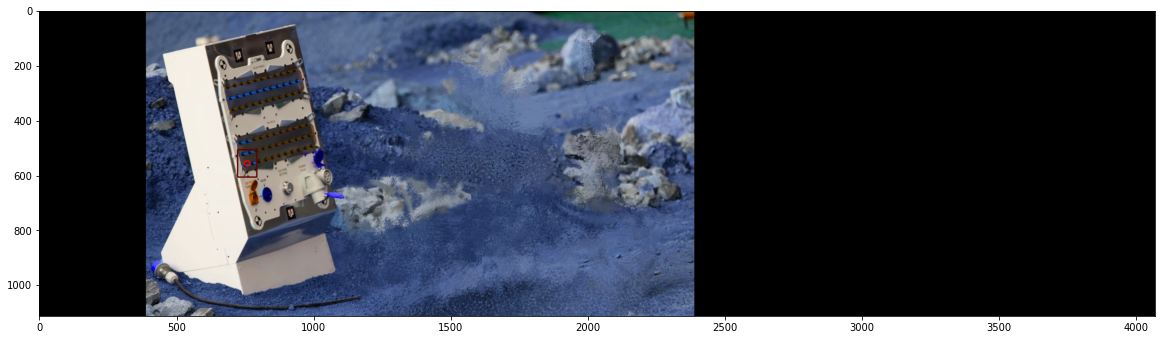

done


In [5]:
# toggles extraction of frame at greater video time
extractFuture=1

# toggles mask extraction
extractMask=0

# toggles greyscaling
convGray=0

# video loading
videosrc='../../images/video/task_ext.avi'
trackcap = cv.VideoCapture(videosrc)

# frame extraction
if trackcap.isOpened():
    capret, capframe = trackcap.read()
    # also extracts frame at greater(future) time from video
    if extractFuture:
        current_framenum=trackcap.get(cv.CAP_PROP_POS_FRAMES)
        frame_time=2000## ms
        # checks if choosen time < video lenght
        if frame_time<=trackcap.get(7)*trackcap.get(5):
            trackcap.set(0, frame_time-1)
            futret,futframe=trackcap.read()
            # resetting video at frame following capframe
            trackcap.set(1,current_framenum)
        else:raise SystemExit("choosen time exceeds video lenght!")
#         plt.figure(figsize=(20,10));plt.imshow(futframe);plt.show()
else: trackcap.release()
cap2frame=capframe.copy

# roi as extracted from video (== roi in extended coord)
# roiframe=capframe[roiy:roiy+roih,roix:roix+roiw]
roiframe=capframe
   
# frame shape   
frameH,frameW,_=capframe.shape
## constant for all video frames

# query extraction
qcx,qcy=rcox,(exthr+hr)//2
# smaller, concentric version of roi
reduxFactor=10
qh,qw=hr//reduxFactor,wr//reduxFactor
qx,qy=qcx-qw//2,qcy-qh//2

showQuery=0## debug
if showQuery:
    cv.rectangle(capframe,(qx,qy),(qx+qw,qy+qh),(255,255,0),3)
    cv.circle(capframe,(qcx,qcy),min(qh//2,qw//2),(255,255,0),3)
    plt.figure(figsize=(20,10));plt.imshow(capframe);plt.show()
    
# choosen query
qframe=capframe[qy:qy+qh,qx:qx+qw]

# masks
if extractMask:
    ## rectangular
    recMask=cv.rectangle(np.zeros((frameH,frameW),np.uint8),\
                (qx,qy),(qx+qw,qy+qh),255,-1)
    ## circular
    cirMask=cv.circle(np.zeros((frameH,frameW),np.uint8),\
                      (qcx,qcy),min(qh//2,qw//2),(255,255,0),-1)

    recframe=cv.bitwise_and(capframe,capframe,mask=recMask)
    cirframe=cv.bitwise_and(capframe,capframe,mask=cirMask)
    
    if 0:## debug
        plt.figure(figsize=(20,10));plt.imshow(recframe);plt.show()
        plt.figure(figsize=(20,10));plt.imshow(cirframe);plt.show()

# random ground region
##test of correct non matching
extractRandom=0
if extractRandom:
    randframe=capframe[500:500+qh,1200:1200+qw]

# QUERY AND TARGET SELECTION #########################################################
query_img=recframe if extractMask else qframe
target_img=futframe if extractFuture else roiframe

# Initiate SIFT detector
sift = cv.xfeatures2d.SIFT_create()

# gray conversion
query_imgg=cv.cvtColor(query_img,cv.COLOR_BGR2GRAY) if convGray else query_img
target_imgg=cv.cvtColor(target_img,cv.COLOR_BGR2GRAY) if convGray else target_img
##is greyscaling really necessary?

# find the keypoints and descriptors with SIFT

query_kp=sift.detect(query_imgg)
target_kp = sift.detect(target_imgg)

showKp=0
if showKp:
    target_img2=cv.drawKeypoints(target_imgg,target_kp,None,flags=cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    query_img2=cv.drawKeypoints(query_imgg,query_kp,None,flags=cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    plt.figure(figsize=(20,10));plt.imshow(target_img2);plt.show()
    plt.figure(figsize=(20,10));plt.imshow(target_img2);plt.show()
    del query_img2,target_img2
    
# Describing keypoints for query and train images
target_kp,target_desc = sift.compute(target_imgg,target_kp)##train
query_kp, query_desc=sift.compute(query_imgg,query_kp)

FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks = 50)
flann = cv.FlannBasedMatcher(index_params, search_params)

matches = flann.knnMatch(query_desc,target_desc,k=2)
good_matches = []
for m,n in matches:
    if m.distance < 0.7*n.distance:
        good_matches.append(m)

# Checking if we found enough matching
MIN_MATCH_COUNT = 10
if len(good_matches)>MIN_MATCH_COUNT:
    # building the corrspondences arrays of good matches
    corSrc_pts = np.float32([ query_kp[m.queryIdx].pt for m in good_matches ]).reshape(-1,1,2)
    corDst_pts = np.float32([ target_kp[m.trainIdx].pt for m in good_matches ]).reshape(-1,1,2)
    # Using RANSAC to estimate a robust homography. 
    # It returns the homography M and a mask for the discarded points
    matcHom, maskTrash = cv.findHomography(corSrc_pts, corDst_pts, cv.RANSAC, 5.0)
    
    # Mask of discarded point used in visualization
    matchesMask = maskTrash.ravel().tolist()
    
    # Corners of the query image
    (hquery,wquery,_) =  query_imgg.shape
    matchPts = np.float32([ [0,0],[0,hquery-1],[wquery-1,hquery-1],[wquery-1,0] ]).reshape(-1,1,2)
    # Projecting the corners into the train image
    destPts = np.int32(cv.perspectiveTransform(matchPts,matcHom))
    # new roi frame
    # new roi center
    (destcenx,destceny)=destcen=((destPts[0]+destPts[2])//2).reshape(2,1,1)[0],\
                                ((destPts[0]+destPts[2])//2).reshape(2,1,1)[1]
    cv.rectangle(target_img,(destcenx-wquery//2,destceny-hquery//2),\
                (destcenx+wquery//2,destceny+hquery//2),100,3)
    ##alternatively:
#     roiframe = cv.polylines(target_img,[destPts],True,255,3, cv.LINE_AA)
    
    cv.circle(target_img,destcen,10,255,3)
    
    
else:
    print( "Not enough matches are found - {}/{}".format(len(good_matches), MIN_MATCH_COUNT) )
    matchesMask = Nonetele
    

plt.figure(figsize=(20,10));plt.imshow(target_img);plt.show();

##############
print('done')

### feature tracking on continuous video

In [6]:
# sift initialization
sift = cv.xfeatures2d.SIFT_create()
# flann initialization
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks = 50)
flann = cv.FlannBasedMatcher(index_params, search_params)
MIN_MATCH_COUNT = 6

videosrc='../../images/video/task_ext.avi'
trackcap = cv.VideoCapture(videosrc)

# first frame
if trackcap.isOpened():
    capret, capframe = trackcap.read()
    frameH,frameW,_=capframe.shape
else: trackcap.release()
#_will be subs with the masked image used for roi    

# greyscaling
convGray=1

##### ROI
# extended roi center
qcx,qcy=rcox,(exthr+hr)//2

# query region for feature tracking, concentric with roi
reduxFactor=12
qh,qw=hr//reduxFactor,wr//reduxFactor
qx,qy=qcx-qw//2,qcy-qh//2## upperleftmost corner
# choosen query
qframe=capframe[qy:qy+qh,qx:qx+qw]

if 0:## debug
    capframe2=capframe.copy()
    cv.rectangle(capframe2,(qx,qy),(qx+qw,qy+qh),(255,255,0),3)
    cv.circle(capframe2,(qcx,qcy),min(qh//2,qw//2),(255,255,0),3)
    plt.figure(figsize=(20,10));plt.imshow(capframe2);plt.show()
    
query_img=qframe
query_imgg=cv.cvtColor(query_img,cv.COLOR_BGR2GRAY) if convGray else query_img
query_kp=sift.detect(query_imgg) 
query_kp, query_desc=sift.compute(query_imgg,query_kp)

while(1):
    capret, capframe = trackcap.read()
    
    if capret == True:
        
        target_img=capframe
        target_imgg=cv.cvtColor(target_img,cv.COLOR_BGR2GRAY) if convGray else target_img
        target_kp = sift.detect(target_imgg)
        target_kp,target_desc = sift.compute(target_imgg,target_kp)

        matches = flann.knnMatch(query_desc,target_desc,k=2)
        good_matches = []
        for m,n in matches:
            if m.distance < 0.7*n.distance:
                good_matches.append(m)


        if len(good_matches)>=MIN_MATCH_COUNT:
            corSrc_pts = np.float32([ query_kp[m.queryIdx].pt for m in good_matches ]).reshape(-1,1,2)
            corDst_pts = np.float32([ target_kp[m.trainIdx].pt for m in good_matches ]).reshape(-1,1,2)
            matcHom, maskTrash = cv.findHomography(corSrc_pts, corDst_pts, cv.RANSAC, 5.0)
            matchesMask = maskTrash.ravel().tolist()
            matchPts = np.float32([ [0,0],[0,qh-1],[qw-1,qh-1],[qw-1,0] ]).reshape(-1,1,2)
            destPts = np.int32(cv.perspectiveTransform(matchPts,matcHom))

            (destcenx,destceny)=destcen=((destPts[0]+destPts[2])//2).reshape(2,1,1)[0],\
                                        ((destPts[0]+destPts[2])//2).reshape(2,1,1)[1]
            cv.rectangle(target_img,(destcenx-qw//2,destceny-qh//2),\
                        (destcenx+qw//2,destceny+qh//2),100,3)
            ##alternatively:
        #     roiframe = cv.polylines(target_img,[destPts],True,255,3, cv.LINE_AA)

            cv.circle(target_img,destcen,10,255,3)
        else:
            print( "Not enough matches are found - {}/{}".format(len(good_matches), MIN_MATCH_COUNT) )
            matchesMask = None

#         plt.figure(figsize=(20,10));plt.imshow(target_img);plt.show();

        cv.imshow('tracking result',target_img)
        k = cv.waitKey(30) & 0xff
        if k == 27:
            break
    else:
        break
# cv.destroyAllWindows()

##############
print('done')

done


In [10]:
# DATA 
videosrc='../../images/video/task_ext.avi'
trackcap = cv.VideoCapture(videosrc)
# first frame
if trackcap.isOpened():
    capret, capframe = trackcap.read()
    frameH,frameW,_=capframe.shape
else: trackcap.release()
#_will be subs with the masked image used for roi    
    
# extended roi center
qcx,qcy=rcox,(exthr+hr)//2
qx,qy=qcx-wr//2,qcy-hr//2
panelTra(capframe,qx,qy,wr,hr,trackcap,trackmethod='feature')

print('done')

NameError: name 'rcox' is not defined